# Creating PFSS models from HMI synoptic maps

Most of this code is taken from [PFSSPy](https://github.com/dstansby/pfsspy).

In [1]:
import drms
import pfsspy
import matplotlib.pylab as plt
import sunpy.map
import numpy as np
import astropy.units as u
import astropy.constants as const

from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import SkyCoord
from pfsspy import coords
from pfsspy import tracing
from astropy.io import fits
from sunpy.cm import color_tables as ct

The first step in querying for SDO HMI and AIA data is to establish a connection to JSOC. This can be done with the `Client()` class.
(Register to download data from JSOC [here](http://jsoc.stanford.edu/ajax/register_email.html)).

In [2]:
c = drms.Client(email='mbobra@stanford.edu', verbose=True)

Query one of two synoptic maps of the radial magnetic field:
 * `hmi.Synoptic_Mr_720s` provides the imputed radial component of the magnetic field over the entire solar disk. The maps are 3600 points in Carrington longitude by 1440 points equally spaced in sine latitude.
 * `hmi.mrsynop_small_720s` is the imputed radial component of the magnetic field over the entire solar disk. The maps are 720 points in Carrington longitude by 360 points equally spaced in sine latitude. This map is produced by applying a boxcar average to the high-resolution map, hmi.Synoptic_Mr_720s.

(Text taken from [JSOC page on synoptic maps](http://jsoc.stanford.edu/HMI/LOS_Synoptic_charts.html))

Query for Carrington rotation number 2194 (associated with the active region that produced the largest X-class flare of the solar cycle):

In [3]:
jsoc_request = c.export('hmi.synoptic_mr_polfil_720s[2194]{Mr_polfil}', protocol='fits')
image_url = jsoc_request.urls['url'][0]
print(image_url)
synoptic_image = fits.open(image_url)

Export request pending. [id="JSOC_20200922_641_X_IN", status=2]
Waiting for 5 seconds...
http://jsoc.stanford.edu/SUM14/D1328997301/S00000/hmi.synoptic_mr_polfil_720s.2194.Mr_polfil.fits


Fix header keywords using the same method in the [SunPy Example Gallery](https://docs.sunpy.org/en/stable/generated/gallery/plotting/hmi_synoptic_maps.html):

In [4]:
synoptic_image[1].header["CUNIT1"] = 'degree'
synoptic_image[1].header["CUNIT2"] = 'degree'
synoptic_image[1].header["CDELT1"] *= -1
synoptic_image[1].header["CDELT2"] = 180 / np.pi * synoptic_image[1].header["CDELT2"]

Delete FITS header keywords that do not conform to the FITS standard 😑

In [5]:
del synoptic_image[1].header["CRDER1"]
del synoptic_image[1].header["CRDER2"]
del synoptic_image[1].header["CSYSER1"]
del synoptic_image[1].header["CSYSER2"]

Add a keyword for `DATE_OBS` (which is the same as `T_OBS`), otherwise the SunPy map will populate the observation time with the current time

In [6]:
synoptic_image[1].header["DATE-OBS"] = synoptic_image[1].header["T_OBS"]

Count the number of NaNs

In [7]:
np.sum(~np.isfinite(synoptic_image[1].data))

0

Create a [SunPy Map object]()

In [8]:
synoptic_map = sunpy.map.Map(synoptic_image[1].data, synoptic_image[1].header)

Look at the data. For some reason the SunPy map is reading the wrong observation date, even though:

In [9]:
synoptic_map.fits_header['DATE-OBS']

'2017.08.30_02:23:18_TAI'

Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,carrington
Wavelength,6173.0
Observation Date,2017-08-30 02:23:18
Exposure Time,0.000000 s
Dimension,[3600. 1440.] pix
Coordinate System,heliographic_carrington
Scale,[0.1 0.07958384] deg / pix
Reference Pixel,[1799. 719.5] pix

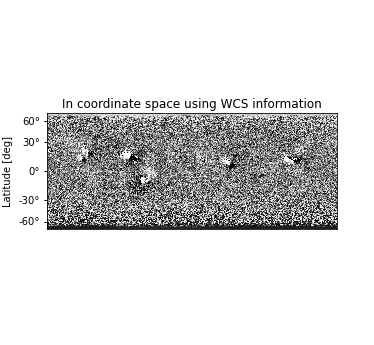
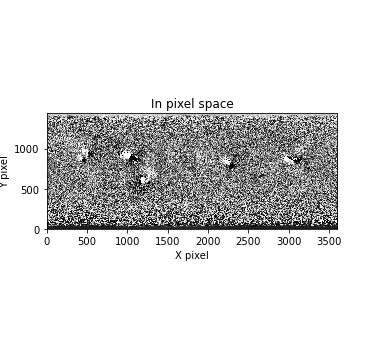
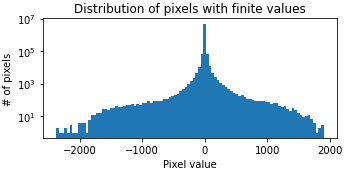

In [10]:
synoptic_map

Downsample map (to make PFSS model run faster)

In [11]:
new_dimensions = [360, 144] * u.pixel
synoptic_map_resampled = synoptic_map.resample(new_dimensions)

Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,carrington
Wavelength,6173.0
Observation Date,2017-08-30 02:23:18
Exposure Time,0.000000 s
Dimension,[360. 144.] pix
Coordinate System,heliographic_carrington
Scale,[1. 0.79583838] deg / pix
Reference Pixel,[179.5 71.5] pix

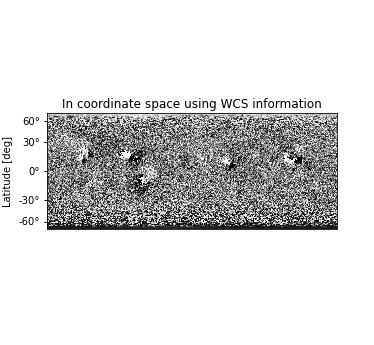
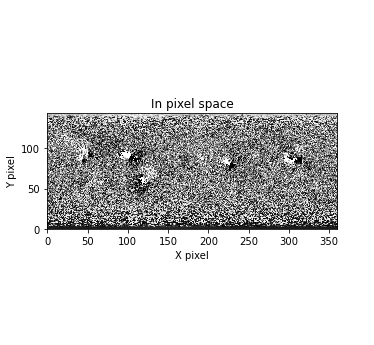
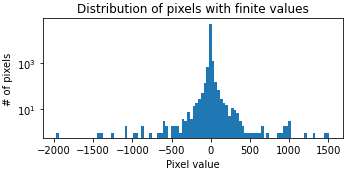

In [12]:
synoptic_map_resampled

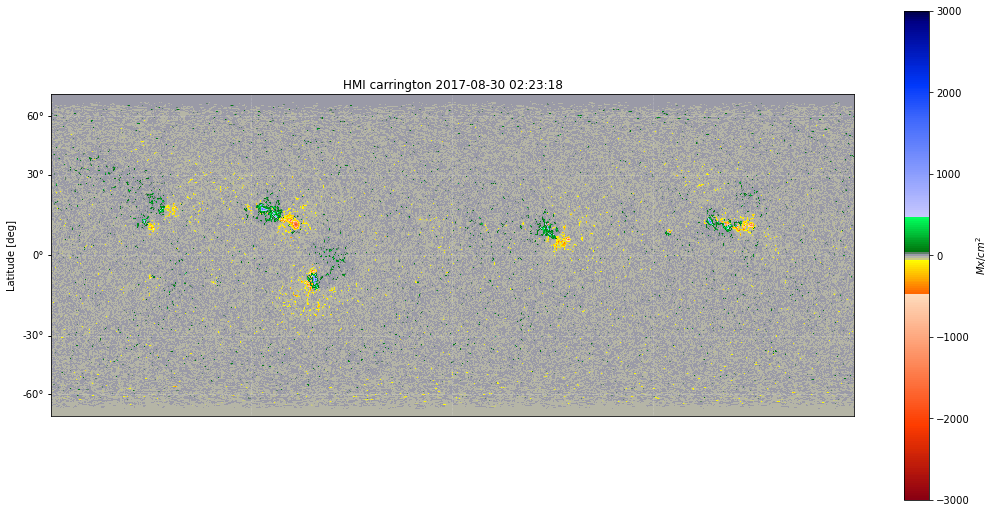

In [13]:
fig = plt.figure(figsize=(18,9))
ax = fig.add_subplot(projection=synoptic_map)
hmimag = plt.get_cmap('hmimag')
im = synoptic_map.plot(vmin=-3000, vmax=3000, cmap=hmimag)
cbar = plt.colorbar(im, label='${Mx}/{cm^2}$')

Generate the PFSS model

In [14]:
nrho = 35
rss = 2.5

In [15]:
input = pfsspy.Input(synoptic_map_resampled, nrho, rss)

Text(0.5, 1.0, 'Input field')

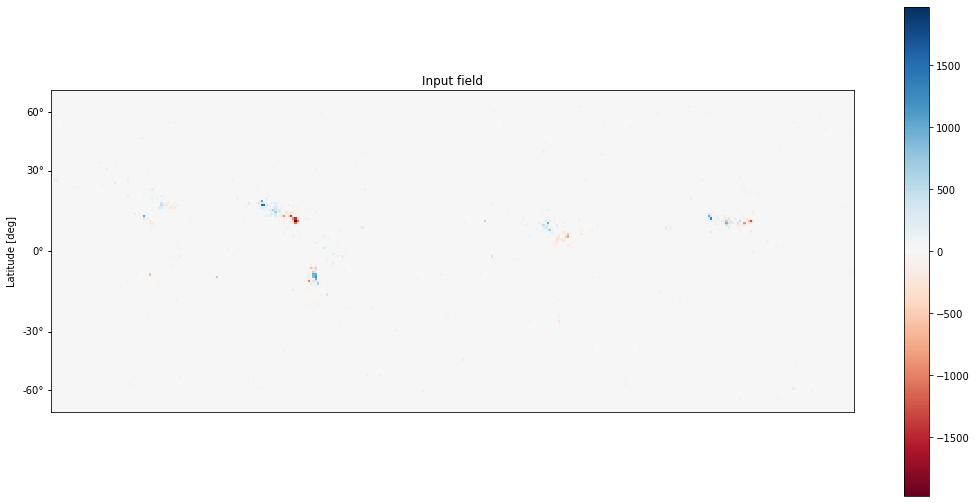

In [16]:
m = input.map
fig = plt.figure(figsize=(18,9))
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()
ax.set_title('Input field')

In [17]:
output = pfsspy.pfss(input)

Plot the source surface field (taken from the [GONG PFSS example](https://pfsspy.readthedocs.io/en/stable/auto_examples/using_pfsspy/plot_gong.html)). The source surface PIL looks like a small blue dot (near -15 degrees latitude).

Text(0.5, 1.0, 'Source surface magnetic field')

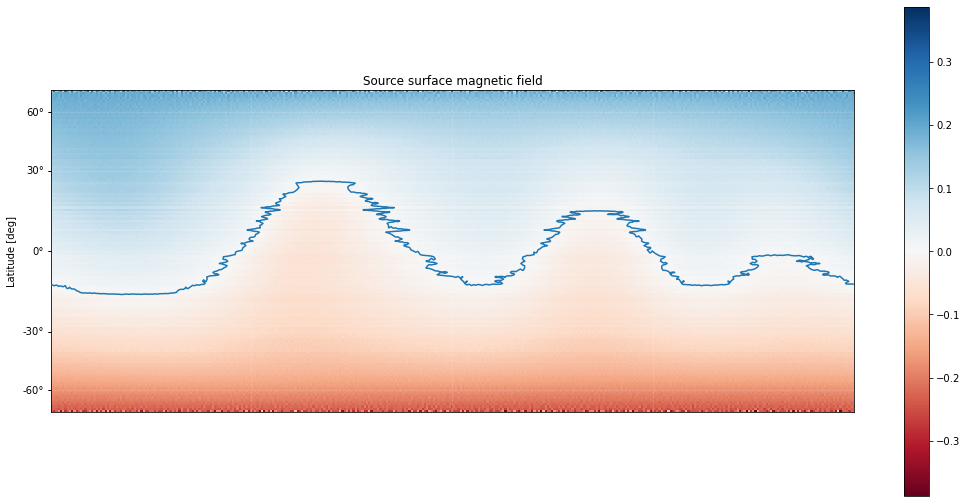

In [18]:
ss_br = output.source_surface_br
fig = plt.figure(figsize=(18,9))
ax = plt.subplot(projection=ss_br)
ss_br.plot()
ax.plot_coord(output.source_surface_pils[1])
plt.colorbar()
ax.set_title('Source surface magnetic field')

The PFSS model identified many polarity inversion lines; most are near the poles

In [19]:
len(output.source_surface_pils)

71

Download AIA data (taken from [overplotting field lines on AIA maps](https://pfsspy.readthedocs.io/en/stable/auto_examples/using_pfsspy/plot_aia_overplotting.html) example)

In [20]:
jsoc_request = c.export('aia.lev1[2017-08-30T02:23:18]{image_lev1}', protocol='fits')
aia_image_url = jsoc_request.urls['url'][0]
print(aia_image_url)
aia_image = fits.open(aia_image_url)

Export request pending. [id="JSOC_20200922_642", status=2]
Waiting for 5 seconds...
Export request pending. [id="JSOC_20200922_642", status=1]
Waiting for 5 seconds...
http://jsoc.stanford.edu/SUM2/D1328998062/S00000/aia.lev1.2017-08-30T022318Z.157285954.image_lev1.fits


In [21]:
aia = sunpy.map.Map(aia_image_url)

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2017-08-30 02:23:16
Exposure Time,2.000048 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600714 0.600714] arcsec / pix
Reference Pixel,[2041.810059 2046.160034] pix

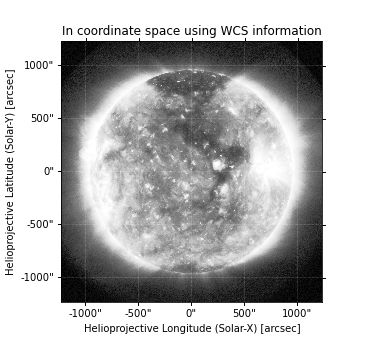
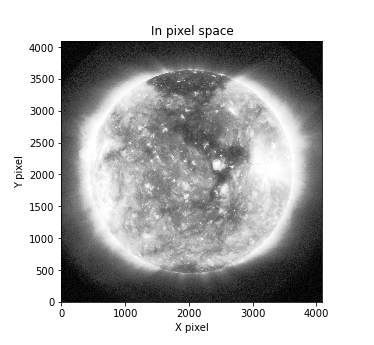
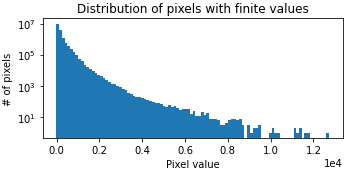

In [22]:
aia

Identify footpoints on the input magnetic field image

s = [0.1   0.125 0.15  0.175 0.2  ]
phi = [55.  57.5 60.  62.5 65. ]
<SkyCoord (HeliographicCarrington: obstime=2017-08-30T02:23:18.000, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-30T02:23:18.000): (lon, lat, radius) in (deg, deg, AU)
    (0., 7.16083864, 1.0096776)>): (lon, lat, radius) in (deg, deg, m)
    [(55. ,  5.73917048, 7.02657e+08), (55. ,  7.18075578, 7.02657e+08),
     (55. ,  8.62692656, 7.02657e+08), (55. , 10.07865811, 7.02657e+08),
     (55. , 11.53695903, 7.02657e+08), (57.5,  5.73917048, 7.02657e+08),
     (57.5,  7.18075578, 7.02657e+08), (57.5,  8.62692656, 7.02657e+08),
     (57.5, 10.07865811, 7.02657e+08), (57.5, 11.53695903, 7.02657e+08),
     (60. ,  5.73917048, 7.02657e+08), (60. ,  7.18075578, 7.02657e+08),
     (60. ,  8.62692656, 7.02657e+08), (60. , 10.07865811, 7.02657e+08),
     (60. , 11.53695903, 7.02657e+08), (62.5,  5.73917048, 7.02657e+08),
     (62.5,  7.18075578, 7.02657e+08), (62.5,  8.62692656, 7.02657e+08),
     (62.5, 10.0786

(0.0, 135.0)

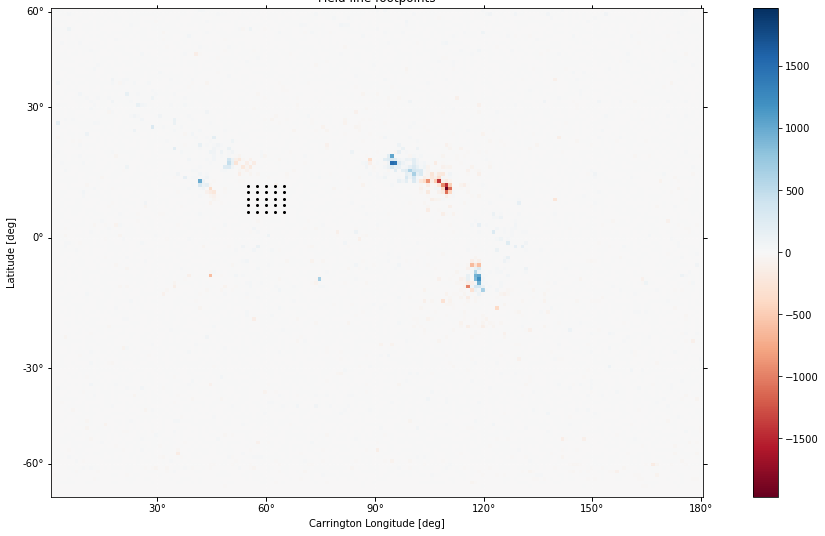

In [23]:
# Create 5 points spaced between sin(lat)={0.1, 0.2}
s = np.linspace(0.1, 0.2, 5)
# Create 5 points spaced between long={55, 65} degrees
phi = np.linspace(55, 65, 5)
print(f's = {s}')
print(f'phi = {phi}')
# Make a 2D grid from these 1D points
s, phi = np.meshgrid(s, phi)

# Now convert the points to a coordinate object
lat = np.arcsin(s) * u.rad
lon = phi * u.deg
seeds = SkyCoord(lon.ravel(), lat.ravel(), 1.01 * const.R_sun, frame=synoptic_map.coordinate_frame)

print(seeds)

m = input.map
fig = plt.figure(figsize=(18,9))
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()

ax.plot_coord(seeds, color='black', marker='o', linewidth=0, markersize=2)

# Set the axes limits. These limits have to be in pixel values
ax.set_xlim(0, 180)
ax.set_ylim(45, 135)
ax.set_title('Field line footpoints')
ax.set_ylim(bottom=0)

Map selected field lines on input photospheric magnetic field

Text(0.5, 1.0, 'Photospheric field and traced field lines')

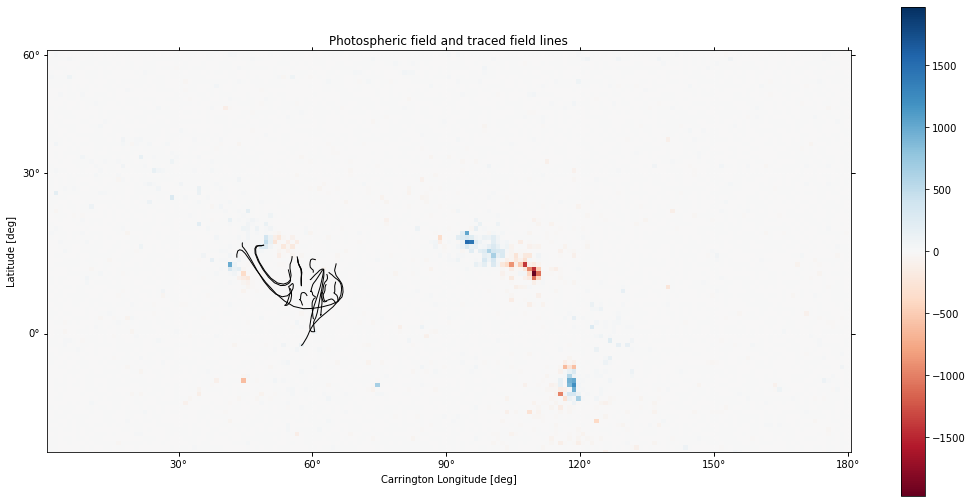

In [24]:
m = input.map
fig = plt.figure(figsize=(18,9))
ax = plt.subplot(projection=m)
m.plot()
plt.colorbar()

tracer = tracing.PythonTracer()
field_lines = tracer.trace(seeds, output)

for field_line in field_lines:
    ax.plot_coord(field_line.coords, color='black', linewidth=1)

# Set the axes limits. These limits have to be in pixel values
ax.set_xlim(0, 180)
ax.set_ylim(45, 135)
ax.set_title('Photospheric field and traced field lines')

Map selected field lines on AIA image

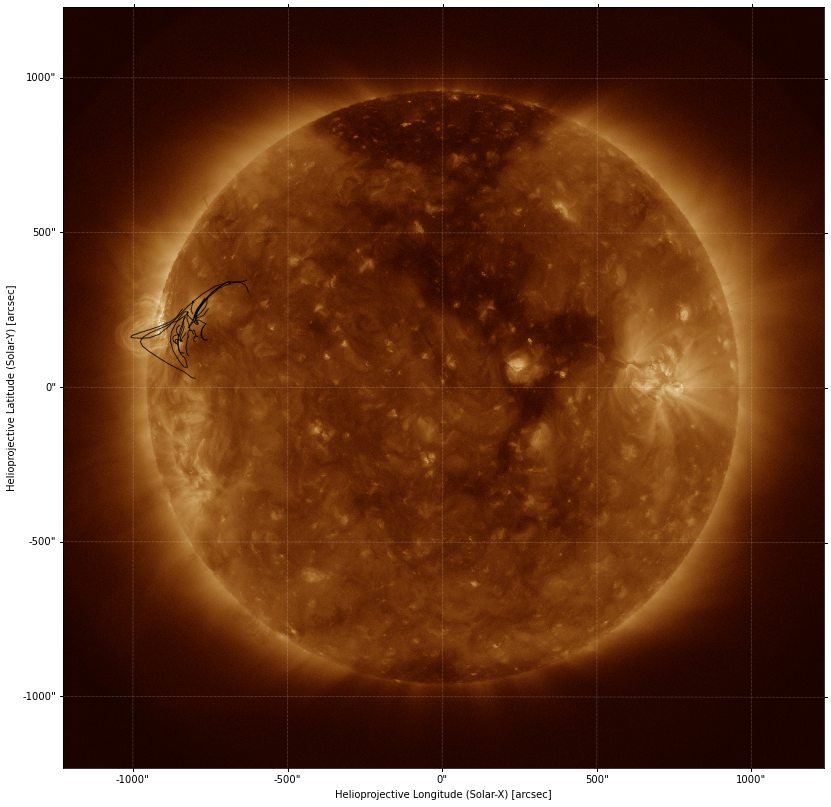

In [25]:
fig = plt.figure(figsize=(14,14))
ax = plt.subplot(1, 1, 1, projection=aia)
aia.plot(ax)

for field_line in field_lines:
    ax.plot_coord(field_line.coords, alpha=0.8, linewidth=1, color='black')

plt.show()